In [27]:
!pip install qiskit

In [28]:
!pip install qiskit-aer

In [29]:
!pip install qiskit-ibm-runtime

In [30]:
!pip install pylatexenc

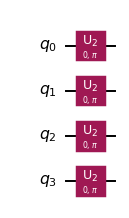

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile
from qiskit_aer.noise import NoiseModel, errors
from qiskit_ibm_runtime import Session, Options, Estimator
from typing import Optional
from abc import ABC, abstractmethod

qc = QuantumCircuit(4)

for i in range(4):
  qc.h(i)

qc.decompose().draw("mpl", scale=0.7)

In [32]:
from qiskit.quantum_info import SparsePauliOp

# Z on the last qubit (index -1) with coefficient 1.0
observable = SparsePauliOp.from_sparse_list([("Z", [-1], 1.0)], num_qubits=4)

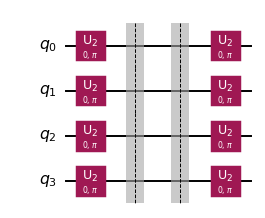

In [33]:
import numpy as np
from qiskit.circuit.library import UnitaryOverlap

# Generate random parameters
rng = np.random.default_rng(1234)
params = rng.uniform(-np.pi, np.pi, size=qc.num_parameters)

# Assign the parameters to the circuit
assigned_qc = qc.assign_parameters(params)

# Add a barrier to prevent qc optimization of mirrored operators
assigned_qc.barrier()

# Construct mirror qc
mirror_qc = UnitaryOverlap(assigned_qc, assigned_qc)

mirror_qc.decompose().draw("mpl", scale=0.7)

In [39]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", token="ff514d54744120dda0e6db45427e4504a17fd5a0f92e2dbf1d37308e8bbd8d86f458b86cd5564a45796eff0bba17926c648a17543a4969d5cf607d0d6908c398")

backend = service.least_busy(min_num_qubits=127)

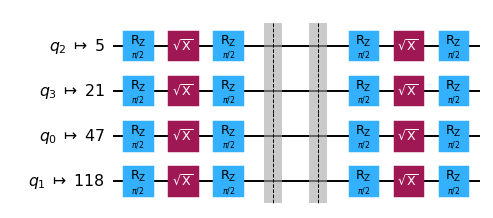

In [40]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=1234
)
isa_circuit = pass_manager.run(mirror_qc)

isa_circuit.draw("mpl", idle_wires=False, scale=0.7, fold=-1)

In [41]:
isa_observable = observable.apply_layout(isa_circuit.layout)

print("Original observable:")
print(observable)
print()
print("Observable with layout applied:")
print(isa_observable)

Original observable:
SparsePauliOp(['ZIII'],
              coeffs=[1.+0.j])

Observable with layout applied:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])


In [43]:
from qiskit_ibm_runtime import Batch, EstimatorV2 as Estimator

pub = (isa_circuit, isa_observable)

jobs = []

with Batch(backend=backend) as batch:
    estimator = Estimator(mode=batch)
    # Set number of shots
    estimator.options.default_shots = 100_000
    # Disable runtime compilation and error mitigation
    estimator.options.optimization_level = 0
    estimator.options.resilience_level = 0

    # Run job with no error mitigation
    job0 = estimator.run([pub])
    jobs.append(job0)

    # Add dynamical decoupling (DD)
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XpXm"
    job1 = estimator.run([pub])
    jobs.append(job1)

    # Add readout error mitigation (DD + TREX)
    estimator.options.resilience.measure_mitigation = True
    job2 = estimator.run([pub])
    jobs.append(job2)

    # Add gate twirling (DD + TREX + Gate Twirling)
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
    job3 = estimator.run([pub])
    jobs.append(job3)

    # Add zero-noise extrapolation (DD + TREX + Gate Twirling + ZNE)
    estimator.options.resilience.zne_mitigation = True
    estimator.options.resilience.zne.noise_factors = (1, 3, 5)
    estimator.options.resilience.zne.extrapolator = ("exponential", "linear")
    job4 = estimator.run([pub])
    jobs.append(job4)

qiskit_runtime_service.check_pending_jobs:WARNING:2024-10-19 01:14:00,213: The pending jobs limit has been reached. Waiting for job <RuntimeJob('cw9g9qybhxtg008ws470', 'estimator')> to finish before submitting the next one.


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the job results
results = [job.result() for job in jobs]

counts = [job.result().get_counts() for job in jobs]

# Unpack the PUB results (there's only one PUB result in each job result)
pub_results = [result[0] for result in results]

# Unpack the expectation values and standard errors
expectation_vals = np.array([float(pub_result.data.evs) for pub_result in pub_results])
standard_errors = np.array([float(pub_result.data.stds) for pub_result in pub_results])


# Plot the expectation values
fig, ax = plt.subplots()
labels = ["No mitigation", "+ DD", "+ TREX", "+ Twirling", "+ ZNE"]
ax.bar(range(len(labels)), expectation_vals, yerr=standard_errors, label="experiment")
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="upper left")

plt.show()

In [ ]:
for pub_result in pub_results:
  print(pub_result.data)